In [23]:
import json
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm, trange

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, drop_last=True,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print(len(trainset))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
50000


batch shape: torch.Size([256, 3, 32, 32])


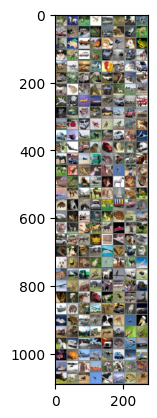

deer  horse deer  plane ship  deer  truck ship  car   cat   frog  deer  plane deer  truck deer  cat   dog   truck car   frog  bird  dog   frog  dog   bird  car   frog  car   ship  truck horse horse plane plane horse bird  truck bird  car   car   frog  truck bird  car   bird  car   cat   horse frog  cat   horse car   deer  horse deer  plane dog   plane plane frog  car   plane truck deer  truck cat   car   car   plane car   ship  ship  car   car   plane bird  bird  frog  dog   truck ship  plane horse horse car   dog   car   bird  plane truck bird  car   dog   dog   truck horse car   plane truck frog  bird  car   horse horse bird  frog  horse dog   bird  bird  cat   car   frog  truck plane deer  horse frog  frog  ship  horse plane horse cat   ship  cat   horse frog  cat   dog   car   deer  car   car   cat   plane frog  plane deer  deer  frog  truck ship  cat   deer  dog   horse horse car   cat   bird  car   truck deer  car   cat   plane dog   cat   frog  dog   cat   horse ship  frog  truc

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(f"batch shape: {images.shape}")

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [14]:
import torch.nn as nn
import torch.nn.functional as F


class ResNet(nn.Module):
    def __init__(self, depth: int, kernel_size: int, residual: bool):
        super().__init__()
        self.depth = depth
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=10, out_channels=10, kernel_size=kernel_size, padding='same') for i in range(depth)])
        self.residual = residual

    def forward(self, x: torch.Tensor):
        x = F.pad(x, (0, 0, 0, 0, 0, 7, 0, 0), mode='constant', value=0.0)
        for conv in self.convs:
            z = F.relu(conv(x))
            x = x + z if self.residual else z                
        x = torch.mean(x, (2, 3)) # global average pooling
        return x

class GenResNet(nn.Module):
    def __init__(self, depth: int, kernel_size: int):
        super().__init__()
        self.depth = depth
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=10, out_channels=10, kernel_size=kernel_size, padding='same') for i in range(depth)])
        self.layer_cons = nn.Parameter(torch.tril(torch.ones(depth + 1, depth + 1)))

    def forward(self, x: torch.Tensor):
        x = F.pad(x, (0, 0, 0, 0, 0, 7, 0, 0), mode='constant', value=0.0)
        layer_outs = [x]
        for i in range(self.depth + 1):
            layer_x = sum([o * w for o, w in zip(layer_outs, self.layer_cons[i])])
            if i < self.depth:
                layer_outs.append(F.relu(self.convs[i](layer_x)))
            else:
                break
        x = torch.mean(layer_x, (2, 3)) # global average pooling
        return x

In [15]:
import torch.optim as optim

In [36]:
def train(net, trainloader, criterion, optimizer):
    for epoch in (pbar := trange(1)):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs = inputs.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        running_loss = running_loss / (i + 1)
        pbar.set_description(f'loss: {running_loss:.5f}')
    return running_loss

In [37]:
configs = [
    {'model': ResNet, 'model_config': {'depth': 16, 'kernel_size': 5, 'residual': False}},
    {'model': ResNet, 'model_config': {'depth': 16, 'kernel_size': 5, 'residual': True}},
    {'model': GenResNet, 'model_config': {'depth': 16, 'kernel_size': 5}},
]

In [38]:
def count_params(model):
    return len(torch.nn.utils.parameters_to_vector(model.parameters()))

In [ ]:
for config in configs:
    net = torch.compile(config['model'](**config['model_config']).cuda())
    print(f'Model parameter count: {count_params(net)}')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    final_loss = train(net, trainloader, criterion, optimizer)
    log_line = {'loss': final_loss, 'model_params': count_params(net), **config}
    print(log_line)
    # log to file
    with open('results3.txt', 'a') as f:
        f.write(str(log_line) + "\n")

Model parameter count: 40160


  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
print(f'Parameter count {count_params(net)}')

Parameter count 40449


In [11]:
for r in net.layer_cons:
    for c in r:
        print(f"{c.item():1.2f} ", end='')
    print("")

1.06 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
1.16 1.21 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
1.05 1.04 1.18 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
1.05 0.98 1.14 1.30 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.98 0.90 1.05 1.16 1.18 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.95 0.95 0.97 1.13 1.21 1.11 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.98 0.95 0.97 1.14 1.15 1.11 1.12 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
1.01 1.02 0.96 1.04 1.15 1.14 1.05 1.08 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.96 1.06 1.02 0.98 1.09 1.11 1.03 1.11 1.13 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.93 1.12 1.07 1.02 1.11 1.05 1.03 1.20 1.13 1.23 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
1.06 0.91 1.01 1.02 1.01 1.04 1.04 1.10 1.05 1.10 1.17 0.00 0.00 0.00 0.00 0.00 0.00 
0.87 0.94 1.09 1.03 1.09 0.93 0.98 1.06 1.02 1.03 1.14